In [1]:
import bsm_model as bsm
import yfinance as yf
import pandas as pd
import datetime as datetime
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import griddata

In [2]:
pd.set_option('display.max_rows', 100)

In [25]:
#Define parameters
ticker_symbol = 'NVDA'
r = 0.05

ticker = yf.Ticker(ticker_symbol)
expirations = ticker.options
S = ticker.history(period='1d')['Close'].iloc[0]

# Test
print(f"Current Price of {ticker_symbol}: ${S:.2f}")
print(expirations)

Current Price of NVDA: $178.43
('2025-09-26', '2025-10-03', '2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-04-17', '2026-05-15', '2026-06-18', '2026-08-21', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17', '2028-01-21')


In [26]:
# Loop through expiries and build a list of all options
all_options_list = []

# Iterate over expiry dates
for expiry in expirations:
    chain = ticker.option_chain(expiry)
    # print(chain)

    expiry_date = pd.to_datetime(expiry) 
    today = pd.to_datetime('today').normalize() # set time of date to 0
    days_to_expiry = (expiry_date - today).days

    # Skip currrent option expiry if expire in 2 days
    if days_to_expiry < 2:
        continue

    T = days_to_expiry / 365.25 # Convert to annual

    for option_type_df in [chain.calls, chain.puts]:
        df = option_type_df.copy() # One level deep copy (shallow)

        # Filter low liquidity data; keep volume >= 1 or open interest >= 10
        df = df[(df['volume'] >= 1) | (df['openInterest'] >= 10)]
        # df = df[((df['bid'] + df['ask']) / 2 ) < 0.5] # Ideally, we analyse options with low spread; ensnures our marketPrice estimate is reliable
        # New column market price for better estimate of option price
        df['marketPrice'] = np.where((df['bid'] > 0) & (df['ask'] > 0), (df['bid'] + df['ask']) / 2, df['lastPrice'])
        # use bid and ask price when market is open, otherwise fallback on lastPrice
        df = df[df['marketPrice'] > 0.1] # Option prices this low is noisy data?

        if df.empty:
            continue
            
        df['T'] = T
        # Use strike for moneyness, standardise using stock price
        df['Moneyness'] = df['strike'] / S

        # calculate IV 
        option_type = 'call' if 'C' in df['contractSymbol'].iloc[0] else 'put'
        df['IV'] = df.apply(
            lambda row: bsm.implied_volatility(row['marketPrice'], S, row['strike'], T, r, option_type), axis = 1
        )

        # Negative IV check; make sure data and calculations are valid
        if (df['IV'] < 0).any():
            error_message = (f"Negative IV DETECTED in expiry {expiry} for {option_type}s\n"
                             f"May be data quality issue (arbitrage) / calculation error"
                            )
            raise ValueError(error_message)
        # End of data check

        
        # Add data points to master list, drop NA data points 
        all_options_list.append(df[['Moneyness', 'T', 'IV']].dropna())

master_df = pd.concat(all_options_list)
print(f"\n Successfully processed {len(master_df)} liquid options across {len(expirations)} expiries")
print(master_df.head(10))



 Successfully processed 2266 liquid options across 21 expiries
    Moneyness         T        IV
23   0.882699  0.005476  1.222108
24   0.896710  0.005476  0.875277
25   0.910721  0.005476  0.982610
26   0.924732  0.005476  0.726178
27   0.938744  0.005476  0.699085
28   0.952755  0.005476  0.610208
29   0.966766  0.005476  0.582149
30   0.980777  0.005476  0.537753
31   0.994788  0.005476  0.512590
32   1.008799  0.005476  0.503168


In [31]:
# Define the grid
# Analyse the 25 ITM - 25 OTM; Most liquidity in this region
x_min, x_max = 0.75, 1.25 
y_min, y_max = master_df['T'].min(), master_df['T'].max()

# Create a uniform grid (evenly spread) of (x, y) points to plot volatility surface
# cartesion product of the two sets
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, 100), 
    np.linspace(y_min, y_max, 50)
)

# Create the coordinate points; x and y. z 
points = master_df[['Moneyness', 'T']].values
values = master_df['IV'].values

# Check 
#print(points)
#print(values)

# Interpolate using points, values; estimates the z values for uniform grid points
grid_z_raw = griddata(points, values, (grid_x, grid_y), method = 'linear')

# Note that these estimates give negative z values (negative IVs); The negative IVs are set to zero
#grid_z_nan_cleaned = np.nan_to_num(grid_z_raw) #replace NaN with 0
grid_z = np.maximum(grid_z_raw, 0) # replace negative entries with 0 for 'cubic' interpolation

# Cubic seems to make over/under estimates for IV; since data is clustered around particular time to maturity rather than evenly spread out
# Go with linear interpolation


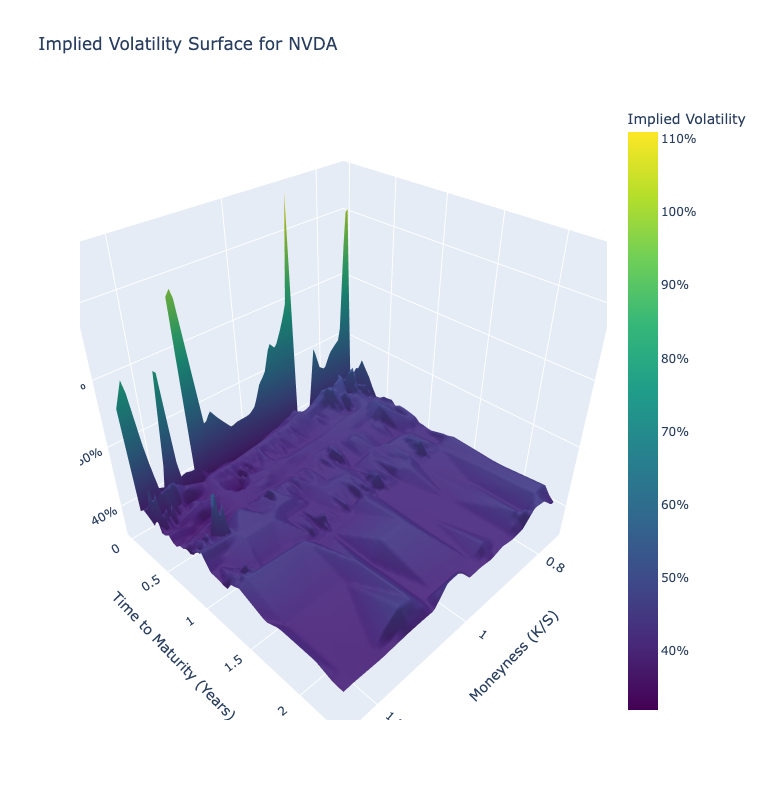

In [32]:
# Construct the surface
fig = go.Figure(data=[go.Surface(
    x = grid_x, 
    y = grid_y, 
    z = grid_z,
    colorscale = 'viridis',
    colorbar = dict(title='Implied Volatility', tickformat = ".0%"), # display as percentage
    cmin = np.nanmin(grid_z), 
    cmax = np.nanmax(grid_z)
)])

# Graph naming 
fig.update_layout(
    title=f'Implied Volatility Surface for {ticker_symbol.upper()}',
    scene=dict(
        xaxis_title='Moneyness (K/S)',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (σ)',
        zaxis=dict(tickformat=".0%")
    ),
    width=900, height=800
)

fig.show()